# Deep Learning, GPU's e modelos pré-treinados

## Montando o drive para acessar os dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Testando se há GPU

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Versão do linux do colab
# !cat /etc/*release

# Versão das bibliotecas
# !pip freeze

## Adaptando os imports da aula passada para uso de GPU

Observe que dessa vez vamos utilizar o keras do tensorflow.

In [ ]:
# data structure
import pandas as pd
import numpy as np
import itertools

# utils
from sklearn.preprocessing import LabelEncoder
import glob
import os
from shutil import copyfile

# metrics
from sklearn.metrics import confusion_matrix

# train test split
from sklearn.model_selection import train_test_split

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# keras with tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MaxPooling2D as MaxPool2D
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers, Model

def make_history_plot(history):
    import matplotlib.pyplot as plt

    plt.plot(history.history["loss"], "b")
    plt.xlabel("Epochs")
    plt.ylabel("Validation score")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Comparando o tempo do código da aula passada com GPU e tensorflow

Epoch 1/3
440/440 - 6s - loss: 0.2517 - accuracy: 0.9191 - val_loss: 0.0595 - val_accuracy: 0.9810 - 6s/epoch - 15ms/step
Epoch 2/3
440/440 - 4s - loss: 0.0764 - accuracy: 0.9774 - val_loss: 0.0412 - val_accuracy: 0.9874 - 4s/epoch - 8ms/step
Epoch 3/3
440/440 - 4s - loss: 0.0568 - accuracy: 0.9838 - val_loss: 0.0353 - val_accuracy: 0.9917 - 4s/epoch - 9ms/step
132/132 [==============================] - 0s 2ms/step
CPU times: user 15.7 s, sys: 845 ms, total: 16.5 s
Wall time: 27.5 s


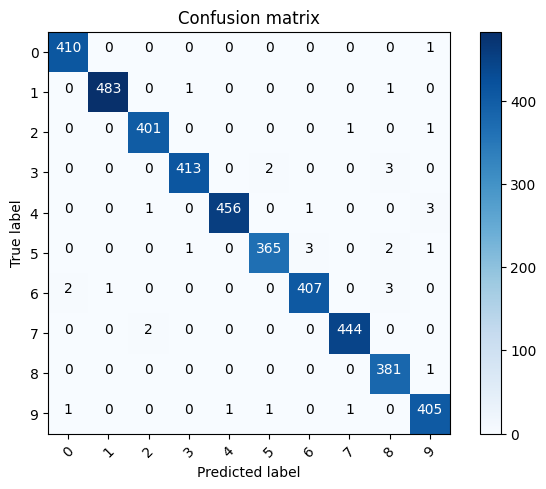

In [ ]:
%%time
# load
train = pd.read_csv("/content/drive/MyDrive/datasets/digits/train.csv")

# get target
Y_train = train["label"]

# drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train

# normalize the data
X_train = X_train / 255.0

# reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)

# encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# set the random seed
random_seed = 2

# split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size = 0.1,
    random_state=random_seed)

# define cnn model
def tensor_keras_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    optimizer = RMSprop(
        learning_rate=0.001, rho=0.9,
        epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# instanciate model
model = tensor_keras_model()

model.fit(
    X_train, Y_train,
    batch_size = 86,
    epochs = 3, # rise it, if you can
    validation_data = (X_val, Y_val), verbose = 2)

# predict the values from the validation dataset
Y_pred = model.predict(X_val)

# convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Resultado no computador pessoal sem GPU e com 3 épocas
- CPU times: total: 10min 27s
- Wall time: 4min 46s

## Aumentando o número de épocas e o batch

In [ ]:
%%time
model.fit(
    X_train, Y_train,
    batch_size = 264,
    epochs = 30, # rise it, if you can
    validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/30
144/144 - 3s - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.0326 - val_accuracy: 0.9924 - 3s/epoch - 20ms/step
Epoch 2/30
144/144 - 3s - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.0385 - val_accuracy: 0.9905 - 3s/epoch - 18ms/step
Epoch 3/30
144/144 - 2s - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0374 - val_accuracy: 0.9900 - 2s/epoch - 17ms/step
Epoch 4/30
144/144 - 3s - loss: 0.0229 - accuracy: 0.9930 - val_loss: 0.0381 - val_accuracy: 0.9879 - 3s/epoch - 18ms/step
Epoch 5/30
144/144 - 3s - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.0296 - val_accuracy: 0.9929 - 3s/epoch - 18ms/step
Epoch 6/30
144/144 - 3s - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0282 - val_accuracy: 0.9931 - 3s/epoch - 18ms/step
Epoch 7/30
144/144 - 3s - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0372 - val_accuracy: 0.9910 - 3s/epoch - 18ms/step
Epoch 8/30
144/144 - 3s - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0303 - val_accuracy: 0.9929 - 3s/epoch - 18ms/step
Epoch 9/30
144/1

## Comparando os resultados

132/132 [==============================] - 0s 2ms/step


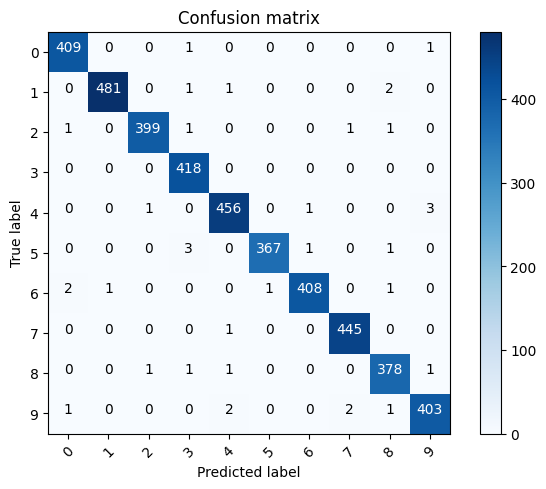

In [ ]:
# predict the values from the validation dataset
Y_pred = model.predict(X_val)

# convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

## Salvando pesos do modelo

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Carregando pesos salvos do json

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


## Fazendo classificações

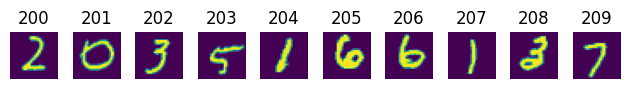

In [ ]:
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(X_val[200+i-1].reshape(28,28))
  plt.title(str(200+i-1))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
np.argmax(loaded_model.predict(X_val[200:210]), axis=-1)

1/1 [==============================] - 0s 34ms/step


array([2, 0, 3, 5, 1, 6, 6, 1, 3, 7])

## Usando modelos pré-treinados VGG

O objetivo é organizar as fotos das férias em pastas separadas por tipo de foto

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet')

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
flowers = ['daisy', 'pot']
birds = [
    'goldfinch', 'European_gallinule', 'brambling',
    'peacock', 'indigo_bunting', 'lorikeet',
    'bulbul', 'great_grey_owl', 'hen',
]

In [ ]:
# folder name
FOLDER_NAME = "/content/drive/MyDrive/datasets/vacationImages"

# number of files
num_files = len(glob.glob(FOLDER_NAME + "/*.jpg"))
print(num_files)

21


In [ ]:
# create new folders
os.mkdir(FOLDER_NAME + "/flowers")
os.mkdir(FOLDER_NAME + "/birds")
os.mkdir(FOLDER_NAME + "/none")

In [ ]:
# classify image with model
def predict_image(filename, model):
    original = load_img(filename,target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    processed_image = vgg16.preprocess_input(image_batch.copy())
    return decode_predictions(
        vgg_model.predict(processed_image))[0][0][1]

In [ ]:
for i in range(num_files):
    filename = FOLDER_NAME + "/" + str(i) + ".jpg"
    pred = predict_image(filename, vgg_model)
    if  pred in flowers:
        copyfile(filename, FOLDER_NAME + '/flowers/' + str(pred) + ".jpg")
    elif pred in birds:
        copyfile(filename, FOLDER_NAME + '/birds/' + str(pred) + ".jpg")
    else:
        copyfile(filename, FOLDER_NAME + '/none/' + str(pred) + ".jpg")

1/1 [==============================] - 0s 18ms/step


## Extendendo modelos pré-treinados

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/datasets/digits/train.csv")

X = train.drop(["label"],axis = 1)
y = train["label"]

X = X / 255.0
X = X.values.reshape(-1,28,28,1)

y = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.1,random_state=42)

# main model
vgg = VGG16(include_top=False, weights='imagenet')

# first layers
x_in = layers.Input(shape=(32, 32, 1))
x = Conv2D(3, 1)(x_in) # Expand to 3 channel with Convolution
x = vgg(x)

# last_layers
x = layers.Flatten()(x)
x = layers.Dense(10, activation='softmax')(x)
model = Model(x_in, x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 3)         6         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                                 
Total params: 14,719,824
Trainable params: 14,719,824
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train = tf.image.resize(X_train, (32,32))
X_val = tf.image.resize(X_val, (32,32))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size = 264)

Epoch 1/30
144/144 [==============================] - 18s 88ms/step - loss: 1.2216 - accuracy: 0.5409 - val_loss: 0.2216 - val_accuracy: 0.9429
Epoch 2/30
144/144 [==============================] - 13s 87ms/step - loss: 0.1148 - accuracy: 0.9697 - val_loss: 0.1488 - val_accuracy: 0.9552
Epoch 3/30
144/144 [==============================] - 13s 89ms/step - loss: 0.0554 - accuracy: 0.9852 - val_loss: 0.0667 - val_accuracy: 0.9795
Epoch 4/30
144/144 [==============================] - 13s 92ms/step - loss: 0.0449 - accuracy: 0.9880 - val_loss: 0.0546 - val_accuracy: 0.9852
Epoch 5/30
144/144 [==============================] - 13s 92ms/step - loss: 0.0351 - accuracy: 0.9911 - val_loss: 0.0457 - val_accuracy: 0.9876
Epoch 6/30
144/144 [==============================] - 13s 93ms/step - loss: 0.0237 - accuracy: 0.9937 - val_loss: 0.0304 - val_accuracy: 0.9914
Epoch 7/30
144/144 [==============================] - 13s 93ms/step - loss: 0.0270 - accuracy: 0.9926 - val_loss: 0.0694 - val_accuracy:

132/132 [==============================] - 1s 7ms/step


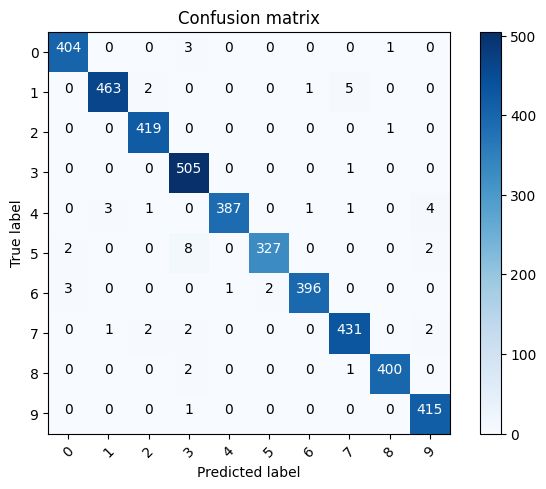

In [ ]:
# predict the values from the validation dataset
y_pred = model.predict(X_val)

# convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)

# convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

## Exercícios

- Submeta uma solução para o desafio: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition

## Onde baixar modelos pré-treinados?

- https://tfhub.dev/

## Modelos interessantes para olhar

- Yolo https://github.com/ultralytics/yolov5
- Stable Difusion https://github.com/Stability-AI/stablediffusion
- MaskRCNN https://github.com/matterport/Mask_RCNN
- Pix2PIx https://phillipi.github.io/pix2pix/
- Keras_OCR https://github.com/faustomorales/keras-ocr

## Referências

- https://machinelearningmastery.com/save-load-keras-deep-learning-models/
- https://www.kaggle.com/code/thitiwat/digit-recognizer-with-vgg16